# Trabajo Integrador Parte 4

Nombre:

Dentro de la carpeta de `data/` vamos a poder encontrar 3 datasets:

- Pokemon (Problema de clasificacion Binaria): La intención es tratar de predecir si basada en la información que tenemos podemos estimar si la carta que estamos viendo es Legendaria o no (Booleano).
- Heart Disease (Problema de clasificacion Binaria): A partir de este dataset vamos a tratar de determinar si una persona basado en ciertos datos tiene asociado una enfermedad cardiaca.
- Challenger USA Space Shuttle O-Ring Data Set (Regresion multivariada): En este dataset encontramos información sobre varios despegues del space shuttle, la intención de este problema es tratar de predecir cuanto será la cantidad de O-Rings que fallan dadas las condiciones de despegue.

> Para la presentación de sus trabajos prácticos **Elijan 1 de los 3 datasets**

# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Cargar datos

Cargar los datos de entrenamiento.

Recordemos que para todos los datasets tenemos el archivo `columns.csv` que contiene el nombre y descripción de cada columna en el mismo orden que van a encontrar los datos.

En los casos de datos con extensión  `*.data` vamos a tener que leerlo utilizando `pd.read_data('myfile.data', sep = ',', header = 0, names = my_cols)`

De esta manera si quisieramos cargar datos por ejemplo de Nasa deberiamos poner algo asi


```python
## Importing python earlier

my_cols = pd.read_csv('./data/nasa_orings/columns.csv').column.values.tolist()

my_data = pd.read_csv('./data/nasa_orings/o-ring-erosion-or-blowby.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )
```

In [100]:
DATASET_PATH = "./data/heart_disease/"

In [101]:
my_cols = pd.read_csv(DATASET_PATH + 'columns.csv').column.values.tolist()

my_data = pd.read_csv(DATASET_PATH + 'processed.cleveland.data',
                       delimiter=',',
                       header=0,
                       names = my_cols
                    )

my_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


# Análisis exploratorio básico y preprocesamiento de los datos

Análisis de los datos para conocer los mismos, ver datos faltantes, decidir cómo tratarlos, ver distribuciones, relaciones, etc. Procesar los datos centrándolos, reescalando, codificando, reduciendo dimensiones, etc. según considere necesario.

Vamos a considerar:

- Para escalar datos: `sklearn.preprocessing.StandardScaler()`
- Para completar valores nulos: `sklearn.impute.SimpleImputer()` [Quickguide](https://scikit-learn.org/stable/modules/impute.html)
- Para reduccion de dimensiones (sobre todo para visualizar los datos): PCA o [T-SNE](https://builtin.com/data-science/tsne-python) (Solo para visualización)
- Para codificar variables categóricas: `sklearn.preprocessing.OneHotEncoder()`

In [102]:
my_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [103]:
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "thalach"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
target = "num"

Una vez separadas las variables por tipo, podemos empezar el analisis. Lo primero es binarizar a la variable target

In [104]:
my_data[target].value_counts()

0    163
1     55
2     36
3     35
4     13
Name: num, dtype: int64

In [105]:
y = my_data[target].values

In [106]:
sano_mask = y == 0
enfermo_mask = y > 0

In [107]:
y_class = y.copy()

y_class[sano_mask] = 0
y_class[enfermo_mask] = 1

In [108]:
y_class= y_class.flatten()

In [109]:
pd.get_dummies(my_data[categorical_features])

,sex,cp,fbs,restecg,exang,slope,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_?,thal_3.0,thal_6.0,thal_7.0,thal_?
0,1.0,4.0,0.0,2.0,1.0,2.0,0,0,0,1,0,1,0,0,0
1,1.0,4.0,0.0,2.0,1.0,2.0,0,0,1,0,0,0,0,1,0
2,1.0,3.0,0.0,0.0,0.0,3.0,1,0,0,0,0,1,0,0,0
3,0.0,2.0,0.0,2.0,0.0,1.0,1,0,0,0,0,1,0,0,0
4,1.0,2.0,0.0,0.0,0.0,1.0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,1.0,0.0,0.0,0.0,2.0,1,0,0,0,0,0,0,1,0
298,1.0,4.0,1.0,0.0,0.0,2.0,0,0,1,0,0,0,0,1,0
299,1.0,4.0,0.0,0.0,1.0,2.0,0,1,0,0,0,0,0,1,0
300,0.0,2.0,0.0,2.0,0.0,2.0,0,1,0,0,0,1,0,0,0


In [110]:
pca = PCA(n_components=0.9).fit(my_data[numerical_features])

pca.n_components_

2

In [111]:
X_transformed = pca.transform(my_data[numerical_features])

In [112]:
X_transformed

array([[ 4.15197276e+01,  6.04359951e+01],
       [-1.75994017e+01,  3.01920764e+01],
       [ 2.12973462e+00, -5.45861630e+01],
       [-4.34743454e+01, -3.24753433e+01],
       [-1.15270317e+01, -3.99676683e+01],
       [ 2.18359694e+01, -1.36251712e+01],
       [ 1.06416100e+02, -2.03988377e+01],
       [ 7.52203752e+00,  4.50457172e+00],
       [-4.33295298e+01, -6.79174957e+00],
       [-5.40858010e+01,  3.61377300e+00],
       [ 4.76163183e+01, -4.88514137e+00],
       [ 9.29523476e+00,  1.06638337e+01],
       [ 1.50008069e+01, -3.47313944e+01],
       [-4.58080508e+01, -1.54606005e+01],
       [-7.77844491e+01, -3.21393208e+01],
       [-1.92309131e+01, -2.71659586e+01],
       [-7.41691526e+00, -1.42000964e+01],
       [ 2.79752555e+01,  1.36751141e+01],
       [ 1.87164266e+01, -3.09825000e+01],
       [-3.63354231e+01,  8.63630131e+00],
       [ 3.71347167e+01, -1.67444313e+01],
       [ 3.66305869e+01, -1.51122588e+01],
       [-2.27632860e+01, -3.20576672e+01],
       [-4.

<Axes: >

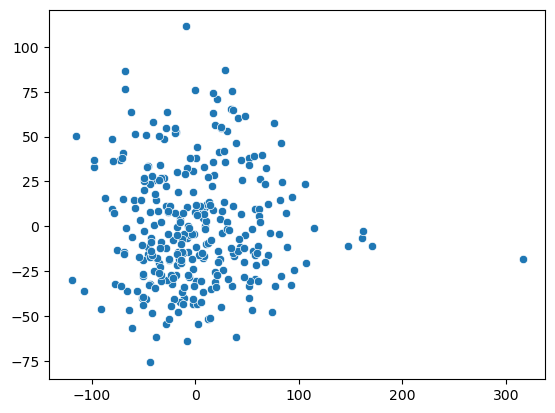

In [113]:
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1])

# Modelos y evaluación
Probar diferentes modelos para predecir la variable objetivo. Calcular las métricas que considere relevantes. Comentar los resultados. 

In [114]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test= train_test_split(X_transformed, y_class, test_size=0.3)
X_train

array([[-7.77844491e+01, -3.21393208e+01],
       [ 1.59370130e+01,  2.25265209e+01],
       [-3.63354231e+01,  8.63630131e+00],
       [-2.63602133e+01,  7.97115678e+00],
       [-9.09854686e+01, -4.62799330e+01],
       [ 3.66265556e+01,  6.50350009e+01],
       [-5.04398105e+01, -4.38861933e+01],
       [ 1.94780647e+01, -3.40591603e+01],
       [ 4.48754674e+01,  2.56337334e+01],
       [ 8.71485239e+01,  7.56050689e+00],
       [-8.60137882e+00,  3.23566788e+01],
       [-6.20865739e+01,  6.36495890e+01],
       [-1.34120046e+01, -3.66314472e+01],
       [ 9.03214278e+00,  2.55015963e-01],
       [-3.78882884e+01, -1.77070053e+01],
       [-2.75422366e+00,  3.05862735e+01],
       [ 2.39974760e+01, -1.82729170e+01],
       [ 5.88277747e+00, -1.46532697e+01],
       [-9.87802233e-02,  7.93186889e+00],
       [ 1.02113305e+01, -9.74302309e+00],
       [ 5.71059845e+01, -1.50960596e+01],
       [-3.85657947e+01, -6.19161230e+01],
       [-4.58080508e+01, -1.54606005e+01],
       [-6.

In [115]:
LR=LogisticRegression()

In [116]:
LR.fit(X_train,y_train)

LogisticRegression()

In [117]:
y_predict_LR=LR.predict(X_test)

In [118]:
y_predict_LR

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0], dtype=int64)

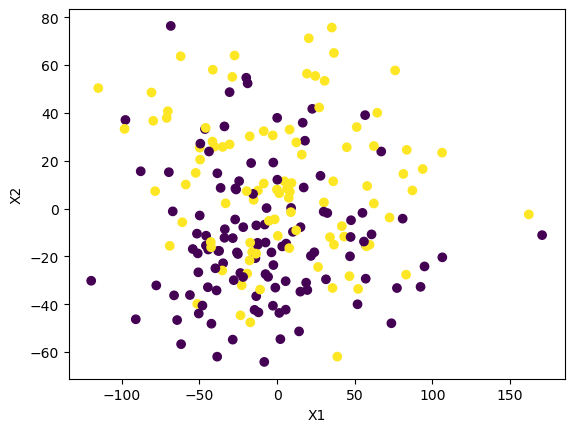

In [119]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

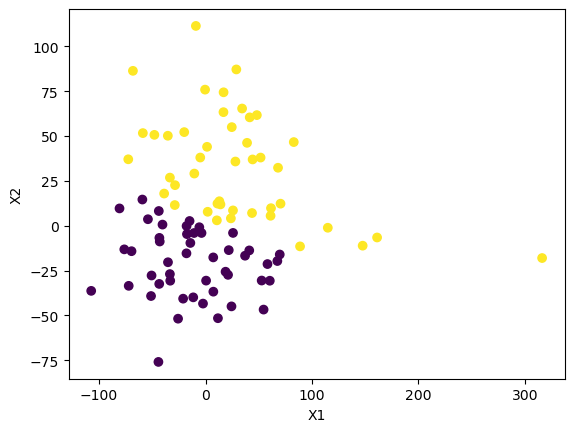

In [120]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict_LR)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [121]:
from sklearn import metrics

In [123]:
conf_matrix_LR=metrics.confusion_matrix(y_test,y_predict_LR)
conf_matrix_LR

array([[35, 12],
       [12, 32]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

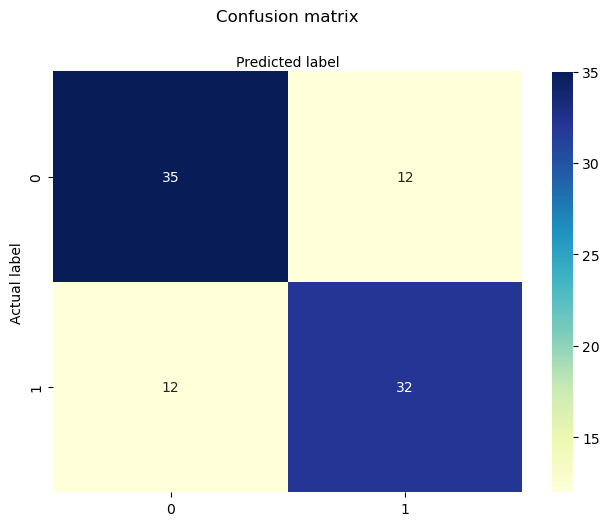

In [124]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix_LR), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [125]:
TP_LR, TN_LR, FP_LR,FN_LR= conf_matrix_LR[0][0], conf_matrix_LR[1][1], conf_matrix_LR[1][0],conf_matrix_LR[0][1]

In [126]:
TP_LR, TN_LR, FP_LR, FN_LR

(35, 32, 12, 12)

In [127]:
accuracy_LR=(TP_LR+TN_LR)/(TP_LR+TN_LR+FP_LR+FN_LR)
specificity_LR=(TN_LR)/(TN_LR+FP_LR)
precision_LR = TP_LR/(TP_LR+FP_LR)
recall_LR=TP_LR/(TP_LR+FN_LR)
print(accuracy_LR, specificity_LR, precision_LR,recall_LR)

0.7362637362637363 0.7272727272727273 0.7446808510638298 0.7446808510638298


In [128]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [129]:
lda = LDA()

In [130]:
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [132]:
y_predict_lda=lda.predict(X_test)
y_predict_lda

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0], dtype=int64)

In [133]:
conf_matrix_LDA=metrics.confusion_matrix(y_test,y_predict_lda)
conf_matrix_LDA

array([[36, 11],
       [13, 31]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

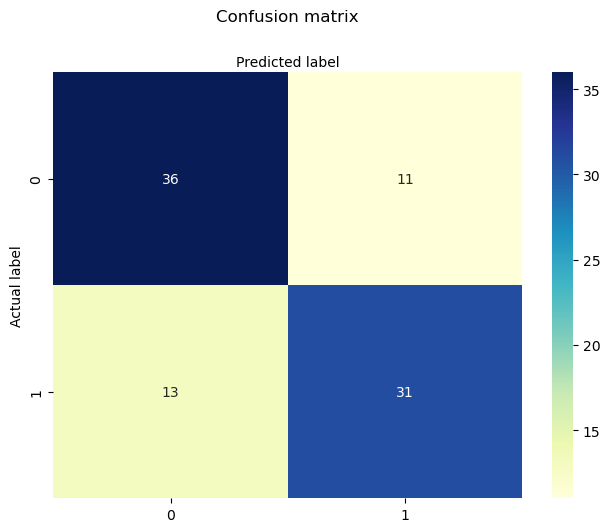

In [134]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix_LDA), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [135]:
TP_LDA, TN_LDA, FP_LDA,FN_LDA= conf_matrix_LDA[0][0], conf_matrix_LDA[1][1], conf_matrix_LDA[1][0],conf_matrix_LDA[0][1]

In [136]:
TP_LDA, TN_LDA, FP_LDA,FN_LDA

(36, 31, 13, 11)

In [137]:
accuracy_LDA=(TP_LDA+TN_LDA)/(TP_LDA+TN_LDA+FP_LDA+FN_LDA)
specificity_LDA=(TN_LDA)/(TN_LDA+FP_LDA)
precision_LDA = TP_LDA/(TP_LDA+FP_LDA)
recall_LDA=TP_LDA/(TP_LDA+FN_LDA)
print(accuracy_LDA, specificity_LDA, precision_LDA,recall_LDA)

0.7362637362637363 0.7045454545454546 0.7346938775510204 0.7659574468085106


In [142]:
Cs = [0.001, 0.01, 0.1, 1, 10]
LRCV = LogisticRegressionCV(Cs=Cs)

In [143]:
LRCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10])

In [144]:
best_C = LRCV.C_
print(best_C)

[0.01]


In [145]:
LR_afterCV=LogisticRegression(C=0.01)

In [146]:
LR_afterCV.fit(X_train,y_train)

LogisticRegression(C=0.01)

In [147]:
y_predict_LRCV=LR_afterCV.predict(X_test)
y_predict_LRCV

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0], dtype=int64)

In [148]:
conf_matrix_LRCV=metrics.confusion_matrix(y_test,y_predict_LRCV)
conf_matrix_LRCV

array([[35, 12],
       [12, 32]], dtype=int64)

In [151]:
TP_CV, TN_CV, FP_CV,FN_CV= conf_matrix_LRCV[0][0], conf_matrix_LRCV[1][1], conf_matrix_LRCV[1][0],conf_matrix_LRCV[0][1]

In [152]:
TP_CV, TN_CV, FP_CV,FN_CV

(35, 32, 12, 12)

In [153]:
accuracy_CV=(TP_CV+TN_CV)/(TP_CV+TN_CV+FP_CV+FN_CV)
specificity_CV=(TN_CV)/(TN_CV+FP_CV)
precision_CV = TP_CV/(TP_CV+FP_CV)
recall_CV=TP_CV/(TP_CV+FN_CV)
print(accuracy_CV, specificity_CV, precision_CV,recall_CV)

0.7362637362637363 0.7272727272727273 0.7446808510638298 0.7446808510638298


In [ ]:
#Ninguno de los tres métodos performa significativamente mejor que el otro (las 4 medidas están a menos de en el orden de magnitud de décimo de porcentaje). Realmente no sé por qué se da esto, imagino porque el Dataset es relativamente simple.